### **Model 2: Logistic Regression**

**Libraries used:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score, recall_score, precision_score

**Getting the dataset ready:**

In [2]:
data = pd.read_csv('./Cleaning Data/cleaned_urdu_articles.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
print("Null Check:", data.isnull().sum().sum())
print("Shape:", data.shape)

X = data['Contents']
y = data['Gold Labels']
seed = 1234
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed) 


label_set = set(y_train)
label_set = list(label_set)
def encode_labels(y):
    y_encoded = []
    for label in y:
        y_encoded.append(label_set.index(label))
    return np.array(y_encoded)

def decode_labels(y):
    y_decoded = []
    for label in y:
        y_decoded.append(label_set[label])
    return np.array(y_decoded)

y_train_encoded = encode_labels(y_train)
y_test_encoded = encode_labels(y_test)

Null Check: 0
Shape: (1610, 5)


In [3]:
class Vector(): # Vectorizing the Text Data by creating a Vocabulary and then converting the text data into Vectors based on Count of Words
    def __init__(self, data):
        self.data = data
        self.vocab = {} # Key: Word, Value: Index in the vector
        self.vocab_size = 0
        for content in self.data:
            for word in content.split():
                if word not in self.vocab:
                    self.vocab[word] = self.vocab_size
                    self.vocab_size += 1
        print("Vocabulary Size:", self.vocab_size)
        
    def vectorize(self, content):
        vector = np.zeros(self.vocab_size)
        for word in content.split():
            if word in self.vocab:
                vector[self.vocab[word]] += 1
        return vector
    
    def vectorize_all(self, data):
        return np.array([self.vectorize(content) for content in data])
    
vectorizer = Vector(X_train)
X_train_vector = vectorizer.vectorize_all(X_train)
X_test_vector = vectorizer.vectorize_all(X_test)
print("X_train_vector Shape:", X_train_vector.shape)
print("X_test_vector Shape:", X_test_vector.shape)

Vocabulary Size: 22798
X_train_vector Shape: (1288, 22798)
X_test_vector Shape: (322, 22798)


**Multi Class Logistic Regression Class:**

In [4]:
class LogisticRegression():
    def __init__(self, learning_rate=0.075, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def crossEnropyLoss(self, h, y):
        # return np.mean(-y * np.log(h) - (1 - y) * np.log(1 - h))
        self.lamda = 0.1
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean() + (self.lamda / (2 * y.size)) * np.sum(self.weights ** 2)
    
    def fit(self, X, y):
        self.weights = np.zeros(X.shape[1])
        self.bias = 0
        self.losses = []
        for i in range(self.num_iterations):
            z = np.dot(X, self.weights) + self.bias
            y_hat = self.sigmoid(z)
            dW = np.dot(X.T, y_hat - y) / y.size
            dB = np.sum(y_hat - y) / y.size
            self.weights -= self.learning_rate * dW
            self.bias -= self.learning_rate * dB
            loss = self.crossEnropyLoss(y_hat, y)
            self.losses.append(loss)
        return self.losses

    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        prob = self.sigmoid(z)
        label = np.where(prob >= 0.5, 1, 0)
        return label, prob
    
    def evaluate(self, y_true, y_pred):
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        confusion = confusion_matrix(y_true, y_pred)
        return accuracy, f1, confusion
    
class MCLR():
    def __init__(self, learning_rate=0.05, num_iterations=2000, num_classes=2):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.num_classes = num_classes
        self.classifiers = {}
        for i in range(num_classes):
            self.classifiers[i] = LogisticRegression(learning_rate, num_iterations)
        self.results = None
        self.combined_results = None
            
    def fit(self, X, y):
        for i in range(self.num_classes):
            y_encoded = np.where(y == i, 1, 0)
            self.classifiers[i].fit(X, y_encoded)
            losses = self.classifiers[i].losses
    
    def evaluate(self, X, y):
        self.results = {}
        for i in range(self.num_classes):
            predictions, probs = self.classifiers[i].predict(X)
            accuracy = accuracy_score(y, predictions)
            f1 = f1_score(y, predictions, average='weighted')
            confusion = confusion_matrix(y, predictions)
            self.results[i] = {'accuracy': accuracy, 'f1': f1, 'confusion': confusion, 'predictions': predictions, 'probs': probs}
        return self.results
    
    def combine(self):
        self.combined_results = np.zeros((X_test_vector.shape[0], self.num_classes))
        for i in range(self.num_classes):
            self.combined_results[:, i] = self.results[i]['probs']
        self.combined_results = np.argmax(self.combined_results, axis=1)
        accuracy = accuracy_score(y_test_encoded, self.combined_results)
        f1 = f1_score(y_test_encoded, self.combined_results, average='weighted')
        confusion = confusion_matrix(y_test_encoded, self.combined_results)
        precision = precision_score(y_test_encoded, self.combined_results, average='weighted')
        recall = recall_score(y_test_encoded, self.combined_results, average='weighted')
        return accuracy, f1, confusion, precision, recall 

**Running the model:**

/var/folders/7n/ssq8qhqs3ng39t12_9znjspw0000gn/T/ipykernel_9878/1438476257.py:13: RuntimeWarning: divide by zero encountered in log
  return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean() + (self.lamda / (2 * y.size)) * np.sum(self.weights ** 2)
/var/folders/7n/ssq8qhqs3ng39t12_9znjspw0000gn/T/ipykernel_9878/1438476257.py:13: RuntimeWarning: invalid value encountered in multiply
  return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean() + (self.lamda / (2 * y.size)) * np.sum(self.weights ** 2)


Results:
---------------------------------------------------


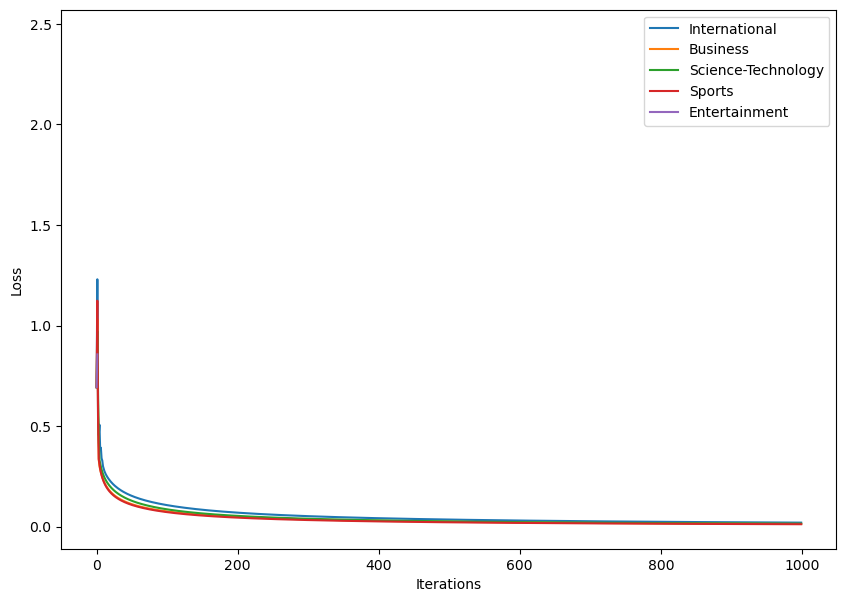

---------------------------------------------------
Accuracy: 0.9409937888198758
F1 Score: 0.9410118337967228
Precision: 0.9414657491217037
Recall: 0.9409937888198758
---------------------------------------------------
Confusion Matrix:


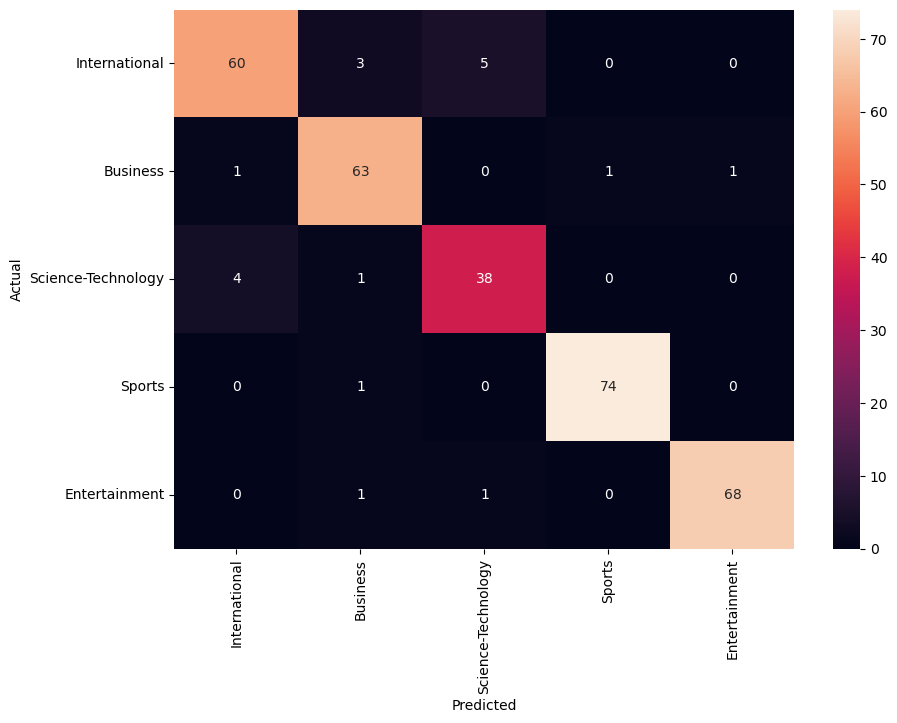

---------------------------------------------------
Classification Report:
                    precision    recall  f1-score   support

     International       0.92      0.88      0.90        68
          Business       0.91      0.95      0.93        66
Science-Technology       0.86      0.88      0.87        43
            Sports       0.99      0.99      0.99        75
     Entertainment       0.99      0.97      0.98        70

          accuracy                           0.94       322
         macro avg       0.93      0.94      0.93       322
      weighted avg       0.94      0.94      0.94       322



In [5]:
mclr = MCLR(learning_rate=0.075, num_iterations=1000, num_classes=len(label_set))
mclr.fit(X_train_vector, y_train_encoded)
results = mclr.evaluate(X_test_vector, y_test_encoded)
accuracy, f1, confusion, precision, recall = mclr.combine()
print("Results:")
print("---------------------------------------------------")
plt.figure(figsize=(10, 7))
for i in range(len(label_set)):
    plt.plot(mclr.classifiers[i].losses, label=label_set[i])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()
print("---------------------------------------------------")
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("---------------------------------------------------")
print("Confusion Matrix:")
plt.figure(figsize=(10, 7))
sns.heatmap(confusion, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.gca().set_xticklabels(label_set, rotation=90)
plt.gca().set_yticklabels(label_set, rotation=0)
plt.show()
print("---------------------------------------------------")
print("Classification Report:")
print(classification_report(y_test_encoded, mclr.combined_results, target_names=label_set))

# writing to file for proper visualisations
ground_truth = decode_labels(y_test_encoded)
LRpredictions = decode_labels(mclr.combined_results)

**Comparision with Sklearn's Logistic Regression:**

Results:
------------------------------------------------------------------
Accuracy: 0.9347826086956522
Precision: 0.9344765716705796
Recall: 0.9347826086956522
F1 Score: 0.9341368614954442
------------------------------------------------------------------
Confusion Matrix:


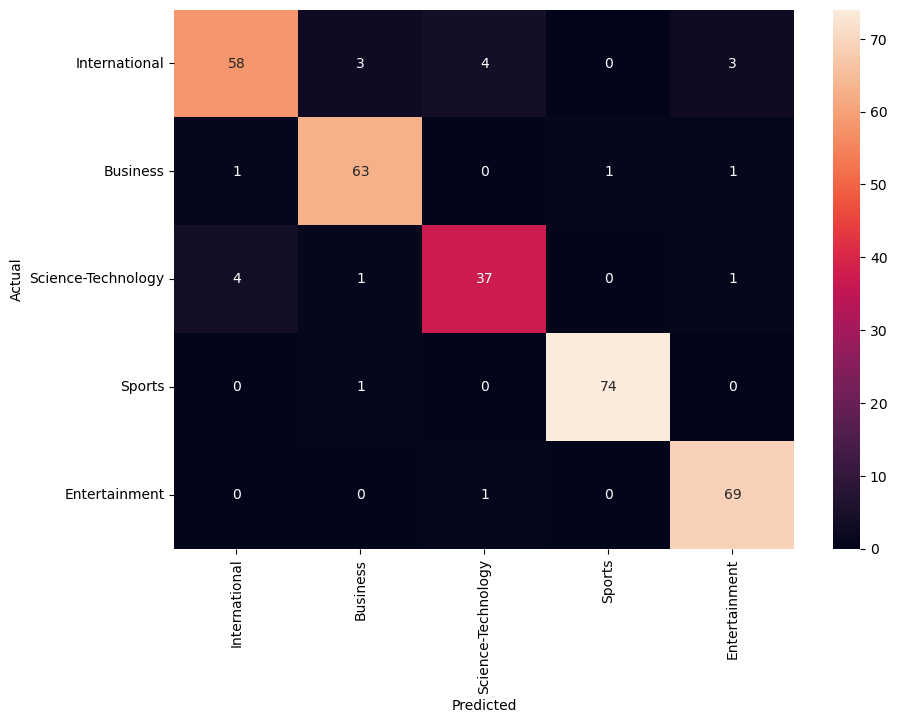

------------------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.85      0.89        68
           1       0.93      0.95      0.94        66
           2       0.88      0.86      0.87        43
           3       0.99      0.99      0.99        75
           4       0.93      0.99      0.96        70

    accuracy                           0.93       322
   macro avg       0.93      0.93      0.93       322
weighted avg       0.93      0.93      0.93       322



In [6]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vector, y_train_encoded)
predictions = model.predict(X_test_vector)
accuracy = accuracy_score(y_test_encoded, predictions)
precision = precision_score(y_test_encoded, predictions, average='weighted')
recall = recall_score(y_test_encoded, predictions, average='weighted')
f1 = f1_score(y_test_encoded, predictions, average='weighted')
confusion = confusion_matrix(y_test_encoded, predictions)
report = classification_report(y_test_encoded, predictions)

print("Results:")
print("------------------------------------------------------------------")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("------------------------------------------------------------------")
print("Confusion Matrix:")
plt.figure(figsize=(10, 7))
sns.heatmap(confusion, annot=True, fmt='d')
plt.gca().set_xlabel('Predicted')
plt.gca().set_ylabel('Actual')
plt.gca().set_xticklabels(label_set, rotation=90)
plt.gca().set_yticklabels(label_set, rotation=0)
plt.show()
print("------------------------------------------------------------------")
print("Classification Report:")
print(report)
SKpredictions = decode_labels(predictions)
results = pd.DataFrame({'Ground Truth': ground_truth, 'SKPredictions': SKpredictions, 'LRPredictions': LRpredictions})
results.to_csv('./Results/Logistic_Regression_Results_Sklearn.csv', index=False)

**Conclusion:**
Our classifier has performed a little bit better than the sklearn? But mostly it seems very similar to SKLEARN.